In [1]:
import os
from PIL import Image
import pandas as pd
import numpy as np
import math
import torch
import torchvision.models as models
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import roc_auc_score, roc_curve, auc, f1_score, average_precision_score
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import copy

# Custom imports
from dataloaders.multilabel_dataset import MultilabelDataset
from dataloaders.ctran_dataset import CTranDataset

from models.resnet import ResNet50
from models.densenet import DenseNet169
from models.mobilenet import MobileNetV2
from models.efficientnet import EfficientNetB3
from models.vit import ViTForMultiLabelClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Data

In [2]:
#### For ViT
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
# ])
#### For CNN
transform = transforms.Compose([
    # Resize
    # transforms.Resize(232), # ResNet50
    transforms.Resize(256),   # DenseNet169, MobileNetV2
    # transforms.Resize(320),   # EfficientNet B3
    
    # CenterCrop
    transforms.CenterCrop(224),
    # transforms.CenterCrop(300), # EfficientNet B3
    
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [3]:
batch_size = 16
num_classes = 28

# train dataset
## Original dataset
# train_dataset = MultilabelDataset(csv_file='data/fundus/RFMiD/Training_Set/new_RFMiD_Training_Labels.csv',
#                               root_dir='data/fundus/RFMiD/Training_Set/Training',
#                               transform=transform)
# train_dataset = CTranDataset(ann_dir='data/fundus/RFMiD/Training_Set/new_RFMiD_Training_Labels.csv',
#                               root_dir='data/fundus/RFMiD/Training_Set/Training',
#                               transform=transform, known_labels=1, testing=False)

## Data augmentation
# train_dataset = MultilabelDataset(csv_file='data/fundus/RFMiD/Training_Set/new_RFMiD_Training_Labels_augmented.csv',
#                               root_dir='data/fundus/RFMiD/Training_Set/Training',
#                               transform=transform)
train_dataset = CTranDataset(ann_dir='data/fundus/RFMiD/Training_Set/new_RFMiD_Training_Labels_augmented.csv',
                              root_dir='data/fundus/RFMiD/Training_Set/Training',
                              transform=transform, known_labels=1, testing=False)



# val dataset
# test_dataset = MultilabelDataset(csv_file='data/fundus/RFMiD/Evaluation_Set/new_RFMiD_Validation_Labels.csv',
#                               root_dir='data/fundus/RFMiD/Evaluation_Set/Validation',
#                               transform=transform)
test_dataset = CTranDataset(ann_dir='data/fundus/RFMiD/Evaluation_Set/new_RFMiD_Validation_Labels.csv',
                              root_dir='data/fundus/RFMiD/Evaluation_Set/Validation',
                              transform=transform, known_labels=0, testing=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Models

### ResNet50

In [7]:
model = ResNet50(num_classes).to(device)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### DenseNet169

In [4]:
model = DenseNet169(num_classes).to(device)
model

DenseNet169(
  (model): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0

### MobileNetV2

In [9]:
model = MobileNetV2(num_classes).to(device)
model

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

### EfficientNetB3

In [6]:
model = EfficientNetB3(num_classes).to(device)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

### ViT

In [4]:
model = ViTForMultiLabelClassification(num_labels=num_classes).to(device)
model

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForMultiLabelClassification(
  (vit): ViTForImageClassification(
    (vit): ViTModel(
      (embeddings): ViTEmbeddings(
        (patch_embeddings): ViTPatchEmbeddings(
          (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): ViTEncoder(
        (layer): ModuleList(
          (0-11): 12 x ViTLayer(
            (attention): ViTAttention(
              (attention): ViTSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
              (output): ViTSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
            )

### C-Tran

In [4]:
def custom_replace(tensor,on_neg_1,on_zero,on_one):
    res = tensor.clone()
    res[tensor==-1] = on_neg_1
    res[tensor==0] = on_zero
    res[tensor==1] = on_one
    return res

In [5]:
class ResNetBackbone(nn.Module):
    def __init__(self):
        super(ResNetBackbone, self).__init__()
        embedding_dim = 2048
        self.freeze_base = False
        self.freeze_base4 = False

        self.base_network = models.resnet101(weights='DEFAULT')
        
        self.base_network.avgpool = nn.AvgPool2d(kernel_size=7,stride=1,padding=0) # replace avg pool
        # self.base_network.avgpool = nn.AvgPool2d(2,stride=2) # replace avg pool
        # print(self.base_network)
        if self.freeze_base:
            for param in self.base_network.parameters():
                param.requires_grad = False
        elif self.freeze_base4:
            for p in self.base_network.layer4.parameters(): 
                p.requires_grad=True

    def forward(self,images):
        x = self.base_network.conv1(images)
        x = self.base_network.bn1(x)
        x = self.base_network.relu(x)
        x = self.base_network.maxpool(x)
        x = self.base_network.layer1(x)
        x = self.base_network.layer2(x)
        x = self.base_network.layer3(x)
        x = self.base_network.layer4(x)
        # x = self.base_network.avgpool(x)
        return x
    
class DenseNetBackbone(nn.Module):
    def __init__(self):
        super(DenseNetBackbone, self).__init__()
        embedding_dim = 1664
        self.base_network = models.densenet169(weights='DEFAULT').features

    def forward(self,images):
        x = self.base_network(images)
        # print(x.shape)
        return x

In [6]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1):
        super(TransformerEncoderLayer, self).__init__()
        # Custom method to return attn outputs. Otherwise same as nn.TransformerEncoderLayer
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.activation = F.relu

    def forward(self, src, src_mask= None, src_key_padding_mask = None):
        src2,attn = self.self_attn(src, src, src, attn_mask=src_mask,key_padding_mask=src_key_padding_mask)
        src = src + self.dropout1(src2) 
        src = self.norm1(src)
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = src + self.dropout2(src2)
        src = self.norm2(src)
        return src,attn
        

class SelfAttnLayer(nn.Module):
    def __init__(self, d_model, nhead = 4,dropout=0.1):
        super().__init__()
        self.transformer_layer = TransformerEncoderLayer(d_model, nhead, d_model*1, dropout=dropout)
        # self.transformer_layer = nn.TransformerEncoderLayer(d_model, nhead, d_model, dropout=dropout, activation='gelu') 

    def forward(self,k,mask=None):
        attn = None
        k=k.transpose(0,1)  
        x,attn = self.transformer_layer(k,src_mask=mask)
        # x = self.transformer_layer(k,src_mask=mask)
        x=x.transpose(0,1)
        return x,attn

In [7]:
def positionalencoding2d(d_model, height, width):
    """
    :param d_model: dimension of the model
    :param height: height of the positions
    :param width: width of the positions
    :return: d_model*height*width position matrix
    """
    if d_model % 4 != 0:
        raise ValueError("Cannot use sin/cos positional encoding with "
                         "odd dimension (got dim={:d})".format(d_model))
    pe = torch.zeros(d_model, height, width)
    # Each dimension use half of d_model
    d_model = int(d_model / 2)
    div_term = torch.exp(torch.arange(0., d_model, 2) *
                         -(math.log(10000.0) / d_model))
    pos_w = torch.arange(0., width).unsqueeze(1)
    pos_h = torch.arange(0., height).unsqueeze(1)
    pe[0:d_model:2, :, :] = torch.sin(pos_w * div_term).transpose(0, 1).unsqueeze(1).repeat(1, height, 1)
    pe[1:d_model:2, :, :] = torch.cos(pos_w * div_term).transpose(0, 1).unsqueeze(1).repeat(1, height, 1)
    pe[d_model::2, :, :] = torch.sin(pos_h * div_term).transpose(0, 1).unsqueeze(2).repeat(1, 1, width)
    pe[d_model + 1::2, :, :] = torch.cos(pos_h * div_term).transpose(0, 1).unsqueeze(2).repeat(1, 1, width)

    return pe

def weights_init(module):
    """ Initialize the weights """
    if isinstance(module, (nn.Linear, nn.Embedding)):
        stdv = 1. / math.sqrt(module.weight.size(1))
        module.weight.data.uniform_(-stdv, stdv)
    if isinstance(module, nn.Linear) and module.bias is not None:
        module.bias.data.uniform_(-stdv, stdv)
    elif isinstance(module, nn.LayerNorm):
        module.bias.data.zero_()
        module.weight.data.fill_(1.0)

In [11]:
class CTranModel(nn.Module):
    def __init__(self,num_labels,use_lmt,pos_emb=False,layers=3,heads=4,dropout=0.1):
        super(CTranModel, self).__init__()
        self.use_lmt = use_lmt

        # image feature backbone
        self.backbone = DenseNetBackbone()
        hidden = 1664 # this should match the backbone output feature size

        self.downsample = False
        if self.downsample:
            self.conv_downsample = torch.nn.Conv2d(hidden,hidden,(1,1))
        
        # Label Embeddings
        self.label_input = torch.Tensor(np.arange(num_labels)).view(1,-1).long()
        self.label_lt = torch.nn.Embedding(num_labels, hidden, padding_idx=None)

        # State Embeddings
        self.known_label_lt = torch.nn.Embedding(3, hidden, padding_idx=0)

        # Position Embeddings (for image features)
        self.use_pos_enc = pos_emb
        if self.use_pos_enc:
            # self.position_encoding = PositionEmbeddingSine(int(hidden/2), normalize=True)
            self.position_encoding = positionalencoding2d(hidden, 18, 18).unsqueeze(0)

        # Transformer
        self.self_attn_layers = nn.ModuleList([SelfAttnLayer(hidden,heads,dropout) for _ in range(layers)])

        # Classifier
        # Output is of size num_labels because we want a separate classifier for each label
        self.output_linear = torch.nn.Linear(hidden,num_labels)
        # self.output_linear = torch.nn.Linear(hidden,1)

        # Other
        self.LayerNorm = nn.LayerNorm(hidden)
        self.dropout = nn.Dropout(dropout)

        # Init all except pretrained backbone
        self.label_lt.apply(weights_init)
        self.known_label_lt.apply(weights_init)
        self.LayerNorm.apply(weights_init)
        self.self_attn_layers.apply(weights_init)
        self.output_linear.apply(weights_init)


    def forward(self,images,mask):
        const_label_input = self.label_input.repeat(images.size(0),1).cuda()
        init_label_embeddings = self.label_lt(const_label_input)

        features = self.backbone(images)
        
        if self.downsample:
            features = self.conv_downsample(features)
        if self.use_pos_enc:
            pos_encoding = self.position_encoding(features,torch.zeros(features.size(0),18,18, dtype=torch.bool).cuda())
            features = features + pos_encoding
        
        features = features.view(features.size(0),features.size(1),-1).permute(0,2,1) 
        
        if self.use_lmt:
            # Convert mask values to positive integers for nn.Embedding
            label_feat_vec = custom_replace(mask,0,1,2).long()

            # Get state embeddings
            state_embeddings = self.known_label_lt(label_feat_vec)

            # Add state embeddings to label embeddings
            init_label_embeddings += state_embeddings
        
        # Concat image and label embeddings
        embeddings = torch.cat((features,init_label_embeddings),1)

        # Feed image and label embeddings through Transformer
        embeddings = self.LayerNorm(embeddings)
        # print(embeddings.size())      
        attns = []
        for layer in self.self_attn_layers:
            embeddings,attn = layer(embeddings,mask=None)
            attns += attn.detach().unsqueeze(0).data

        # Readout each label embedding using a linear layer
        label_embeddings = embeddings[:,-init_label_embeddings.size(1):,:]
        # print(label_embeddings.size())
        output = self.output_linear(label_embeddings) 
        # print(output.size())
        diag_mask = torch.eye(output.size(1)).unsqueeze(0).repeat(output.size(0),1,1).cuda()
        output = (output*diag_mask).sum(-1)
        # output = output.squeeze(-1)

        return output,None,attns

In [12]:
model = CTranModel(num_labels=num_classes,use_lmt=True,pos_emb=False,layers=3,heads=4,dropout=0.1).to(device)
model

CTranModel(
  (backbone): DenseNetBackbone(
    (base_network): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-

# Training

### CNN & ViT Training

In [5]:
selected_data  = 'original' # 'original' or 'augmented' to evaluate the model on the original or augmented dataset
optimizer = optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 30

total_size = len(train_dataset)
val_size = int(total_size * 0.2)
train_size = total_size - val_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

best_val_loss = float('inf')
best_model_state = None
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for batch in train_loader:
        inputs, labels = batch['image'].to(device), batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        # print(outputs.shape, labels.shape)
        loss_out = F.binary_cross_entropy_with_logits(outputs, labels, reduction='none').sum() # sigmoid + BCELoss
        
        train_loss += loss_out.item()
        loss_out.backward()
        optimizer.step()

    # Evaluate the model on the validation set
    model.eval()
    val_loss = 0.0
    # correct_predictions = 0
    total_jaccard_index = 0.0
    total_samples = 0
    auc_scores = []

    with torch.no_grad():
        all_preds = []
        all_labels = []
        all_preds_4 = []
        all_labels_4 = []
        all_preds_5 = []
        all_labels_5 = []
        for batch in val_loader:
            inputs, labels = batch['image'].to(device), batch['labels'].to(device)
            outputs = model(inputs)
            loss_out = F.binary_cross_entropy_with_logits(outputs, labels, reduction='none').sum()
                
            val_loss += loss_out.item()

            # Calculate accuracy
            ## method 1. Strictly Accuracy
            # predicted_labels = (outputs > 0.5).float()
            # correct_predictions += (predicted_labels == labels).all(dim=1).sum().item()
            # total_samples += labels.size(0)
            
            ## method 2. Jaccard Accuracy
            # predicted = (outputs > 0.5).bool()
            # labels_bool = labels.bool()
            # intersection = (predicted & labels_bool).float().sum(dim=1)
            # union = (predicted | labels_bool).float().sum(dim=1)
            # jaccard_index_per_example = intersection / union
            # jaccard_index_per_example[union == 0] = 1.0
            # total_jaccard_index += jaccard_index_per_example.sum().item()
            # total_samples += labels.size(0)
            
            ## method 3. AUC
            outputs_np = F.sigmoid(outputs).cpu().numpy()
            labels_np = labels.cpu().numpy()
            all_preds.extend(outputs_np)
            all_labels.extend(labels_np)
            
            ## method 4. mAP
            all_preds_4.append(F.sigmoid(outputs).cpu())
            all_labels_4.append(labels.cpu())
            
            ## method 5. F1 Score
            predicted = F.sigmoid(outputs).cpu() > 0.5
            all_preds_5.append(predicted.numpy())
            all_labels_5.append(labels.cpu().numpy())

    current_val_loss = val_loss / len(val_loader)
    if current_val_loss < best_val_loss:
        best_val_loss = current_val_loss
        best_model_state = copy.deepcopy(model.state_dict())
    
    if selected_data == 'original':
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss/len(train_loader):.6f}, Validation Loss: {val_loss/len(val_loader):.6f}')
        continue
    
    ## method 1.
    # accuracy = correct_predictions / total_samples
    ## method 2.
    # accuracy = total_jaccard_index / total_samples
    ## method 3.
    for i in range(labels_np.shape[1]):
            label_specific_auc = roc_auc_score([label[i] for label in all_labels], [pred[i] for pred in all_preds])
            auc_scores.append(label_specific_auc)
    average_auc = sum(auc_scores) / len(auc_scores)
    ## method 4. mAP
    all_preds_4 = torch.cat(all_preds_4).numpy()
    all_labels_4 = torch.cat(all_labels_4).numpy()
    mAP = 0
    for i in range(all_labels_4.shape[1]):
        AP = average_precision_score(all_labels_4[:, i], all_preds_4[:, i])
        mAP += AP

    mAP /= all_labels_4.shape[1]
    ## method 5. F1 Score
    all_preds_5 = np.vstack(all_preds_5)
    all_labels_5 = np.vstack(all_labels_5)
    f1_macro = f1_score(all_labels_5, all_preds_5, average='macro')
    
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss/len(train_loader):.6f}, Validation Loss: {val_loss/len(val_loader):.6f}, F1_macro: {f1_macro:.3f}, Average AUC: {average_auc:.3f}, mAP: {mAP:.3f}')


Epoch 1/30, Training Loss: 203.334104, Validation Loss: 117.645742
Epoch 2/30, Training Loss: 85.461980, Validation Loss: 69.317752
Epoch 3/30, Training Loss: 55.438746, Validation Loss: 54.429475
Epoch 4/30, Training Loss: 41.393680, Validation Loss: 46.672699
Epoch 5/30, Training Loss: 32.414038, Validation Loss: 44.575747
Epoch 6/30, Training Loss: 25.304407, Validation Loss: 39.926535
Epoch 7/30, Training Loss: 19.832337, Validation Loss: 39.351467
Epoch 8/30, Training Loss: 15.929421, Validation Loss: 37.983705
Epoch 9/30, Training Loss: 13.169975, Validation Loss: 37.802844
Epoch 10/30, Training Loss: 11.206412, Validation Loss: 36.660313
Epoch 11/30, Training Loss: 9.351773, Validation Loss: 37.161065
Epoch 12/30, Training Loss: 8.830979, Validation Loss: 38.852971
Epoch 13/30, Training Loss: 7.873577, Validation Loss: 36.647919
Epoch 14/30, Training Loss: 6.777152, Validation Loss: 36.202710
Epoch 15/30, Training Loss: 6.107036, Validation Loss: 34.952952
Epoch 16/30, Training 

#### K-Fold Cross Validation

In [6]:
num_epochs = 10

best_val_loss = float('inf')
best_model_state = None

kf = KFold(n_splits=5, shuffle=True, random_state=42)
for fold, (train_idx, val_idx) in enumerate(kf.split(np.arange(len(train_dataset)))):
    print(f"------------------ Fold {fold + 1}/{kf.get_n_splits()} --------------------")
    
    train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
    val_sampler = torch.utils.data.SubsetRandomSampler(val_idx)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
    val_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=val_sampler)
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for batch in train_loader:
            inputs, labels = batch['image'].to(device), batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            # print(outputs.shape, labels.shape)
            loss_out = F.binary_cross_entropy_with_logits(outputs, labels, reduction='none'),sum() # sigmoid + BCELoss
                
            train_loss += loss_out.item()
            loss_out.backward()
            optimizer.step()

        # Evaluate the model on the validation set
        model.eval()
        val_loss = 0.0
        # correct_predictions = 0
        total_jaccard_index = 0.0
        total_samples = 0
        auc_scores = []

        with torch.no_grad():
            
            all_preds = []
            all_labels = []
            all_preds_4 = []
            all_labels_4 = []
            all_preds_5 = []
            all_labels_5 = []
            
            for batch in val_loader:
                inputs, labels = batch['image'].to(device), batch['labels'].to(device)
                outputs = model(inputs)
                loss_out = F.binary_cross_entropy_with_logits(outputs, labels, reduction='none').sum()
                    
                val_loss += loss_out

                # Calculate accuracy
                ## method 1. Strictly Accuracy
                # predicted_labels = (outputs > 0.5).float()
                # correct_predictions += (predicted_labels == labels).all(dim=1).sum().item()
                # total_samples += labels.size(0)
                
                ## method 2. Jaccard Accuracy
                # predicted = (outputs > 0.5).bool()
                # labels_bool = labels.bool()
                # intersection = (predicted & labels_bool).float().sum(dim=1)
                # union = (predicted | labels_bool).float().sum(dim=1)
                # jaccard_index_per_example = intersection / union
                # jaccard_index_per_example[union == 0] = 1.0
                # total_jaccard_index += jaccard_index_per_example.sum().item()
                # total_samples += labels.size(0)
                
                ## method 3. AUC
            outputs_np = F.sigmoid(outputs).cpu().numpy()
            labels_np = labels.cpu().numpy()
            all_preds.extend(outputs_np)
            all_labels.extend(labels_np)
            
            ## method 4. mAP
            all_preds_4.append(F.sigmoid(outputs).cpu())
            all_labels_4.append(labels.cpu())
            
            ## method 5. F1 Score
            predicted = F.sigmoid(outputs).cpu() > 0.5
            all_preds_5.append(predicted.numpy())
            all_labels_5.append(labels.cpu().numpy())


    ## method 1.
    # accuracy = correct_predictions / total_samples
    ## method 2.
    # accuracy = total_jaccard_index / total_samples
    ## method 3.
    for i in range(labels_np.shape[1]):
            label_specific_auc = roc_auc_score([label[i] for label in all_labels], [pred[i] for pred in all_preds])
            auc_scores.append(label_specific_auc)
    average_auc = sum(auc_scores) / len(auc_scores)
    ## method 4. mAP
    all_preds_4 = torch.cat(all_preds_4).numpy()
    all_labels_4 = torch.cat(all_labels_4).numpy()
    mAP = 0
    for i in range(all_labels_4.shape[1]):
        AP = average_precision_score(all_labels_4[:, i], all_preds_4[:, i])
        mAP += AP

    mAP /= all_labels_4.shape[1]
    ## method 5. F1 Score
    all_preds_5 = np.vstack(all_preds_5)
    all_labels_5 = np.vstack(all_labels_5)
    f1_macro = f1_score(all_labels_5, all_preds_5, average='macro')
    
    current_val_loss = val_loss / len(val_loader)
    if current_val_loss < best_val_loss:
        best_val_loss = current_val_loss
        best_model_state = copy.deepcopy(model.state_dict())
    
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss/len(train_loader):.6f}, Validation Loss: {val_loss/len(val_loader):.6f}, F1_macro: {f1_macro:.3f}, Average AUC: {average_auc:.3f}, mAP: {mAP:.3f}')


------------------ Fold 1/5 --------------------
Epoch 1/10, Training Loss: 0.183242, Validation Loss: 0.162271, F1_macro: 0.410, Average AUC: 0.959, mAP: 0.768
Epoch 2/10, Training Loss: 0.097240, Validation Loss: 0.099837, F1_macro: 0.623, Average AUC: 0.979, mAP: 0.887
Epoch 3/10, Training Loss: 0.058607, Validation Loss: 0.071470, F1_macro: 0.749, Average AUC: 0.984, mAP: 0.920
Epoch 4/10, Training Loss: 0.044952, Validation Loss: 0.060589, F1_macro: 0.836, Average AUC: 0.986, mAP: 0.929
Epoch 5/10, Training Loss: 0.025477, Validation Loss: 0.053387, F1_macro: 0.842, Average AUC: 0.987, mAP: 0.934
Epoch 6/10, Training Loss: 0.026616, Validation Loss: 0.048856, F1_macro: 0.873, Average AUC: 0.987, mAP: 0.937
Epoch 7/10, Training Loss: 0.018145, Validation Loss: 0.046023, F1_macro: 0.868, Average AUC: 0.987, mAP: 0.935
Epoch 8/10, Training Loss: 0.021290, Validation Loss: 0.042619, F1_macro: 0.887, Average AUC: 0.987, mAP: 0.938
Epoch 9/10, Training Loss: 0.015322, Validation Loss: 0

### C-Tran Training

In [10]:
num_epochs = 20
optimizer = optim.Adam(model.parameters(), lr=0.00001)
loss_labels = 'all' # 'all' or 'unk'for all labels or only unknown labels loss respectively

total_size = len(train_dataset)
val_size = int(total_size * 0.2)
train_size = total_size - val_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

best_val_loss = float('inf')
best_model_state = None
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for batch in train_loader:
        labels = batch['labels'].float()
        images = batch['image'].float()
        mask = batch['mask'].float()
        unk_mask = custom_replace(mask,1,0,0)
        mask_in = mask.clone()
        
        optimizer.zero_grad()
        pred,int_pred,attns = model(images.to(device),mask_in.to(device))
        # print(pred.shape, labels.shape)
        
        loss =  F.binary_cross_entropy_with_logits(pred.view(labels.size(0),-1),labels.cuda(),reduction='none')
        if loss_labels == 'unk': 
            # only use unknown labels for loss
            loss_out = (unk_mask.cuda()*loss).sum()
        else: 
            # use all labels for loss
            loss_out = loss.sum()
            
        train_loss += loss_out.item()
        loss_out.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    # Evaluate the model on the validation set
    model.eval()
    val_loss = 0.0
    # correct_predictions = 0
    total_jaccard_index = 0.0
    total_samples = 0
    auc_scores = []

    with torch.no_grad():
        
        all_preds = []
        all_labels = []
        all_preds_4 = []
        all_labels_4 = []
        all_preds_5 = []
        all_labels_5 = []
        
        for batch in val_loader:
            labels = batch['labels'].float()
            images = batch['image'].float()
            mask = batch['mask'].float()
            mask_in = mask.clone()
            unk_mask = custom_replace(mask,1,0,0)
            
            pred,int_pred,attns = model(images.to(device),mask_in.to(device))
            
            loss = F.binary_cross_entropy_with_logits(pred.view(labels.size(0),-1),labels.cuda(),reduction='none')
            loss_out = (unk_mask.cuda()*loss).sum()
            val_loss += loss_out

            # Calculate accuracy
            ## method 1. Strictly Accuracy
            # predicted_labels = (outputs > 0.5).float()
            # correct_predictions += (predicted_labels == labels).all(dim=1).sum().item()
            # total_samples += labels.size(0)
            
            ## method 2. Jaccard Accuracy
            # predicted = (outputs > 0.5).bool()
            # labels_bool = labels.bool()
            # intersection = (predicted & labels_bool).float().sum(dim=1)
            # union = (predicted | labels_bool).float().sum(dim=1)
            # jaccard_index_per_example = intersection / union
            # jaccard_index_per_example[union == 0] = 1.0
            # total_jaccard_index += jaccard_index_per_example.sum().item()
            # total_samples += labels.size(0)
            
            ## method 3. AUC
            outputs_np = F.sigmoid(pred).cpu().numpy()
            labels_np = labels.cpu().numpy()
            all_preds.extend(outputs_np)
            all_labels.extend(labels_np)
            
            ## method 4. mAP
            all_preds_4.append(F.sigmoid(pred).cpu())
            all_labels_4.append(labels.cpu())
            
            ## method 5. F1 Score
            predicted = F.sigmoid(pred).cpu() > 0.5
            all_preds_5.append(predicted.numpy())
            all_labels_5.append(labels.cpu().numpy())


    ## method 1.
    # accuracy = correct_predictions / total_samples
    ## method 2.
    # accuracy = total_jaccard_index / total_samples
    ## method 3.
    for i in range(labels_np.shape[1]):
            label_specific_auc = roc_auc_score([label[i] for label in all_labels], [pred[i] for pred in all_preds])
            auc_scores.append(label_specific_auc)
    average_auc = sum(auc_scores) / len(auc_scores)
    ## method 4. mAP
    all_preds_4 = torch.cat(all_preds_4).numpy()
    all_labels_4 = torch.cat(all_labels_4).numpy()
    mAP = 0
    for i in range(all_labels_4.shape[1]):
        AP = average_precision_score(all_labels_4[:, i], all_preds_4[:, i])
        mAP += AP

    mAP /= all_labels_4.shape[1]
    ## method 5. F1 Score
    all_preds_5 = np.vstack(all_preds_5)
    all_labels_5 = np.vstack(all_labels_5)
    f1_macro = f1_score(all_labels_5, all_preds_5, average='macro')
    
    current_val_loss = val_loss / len(val_loader)
    if current_val_loss < best_val_loss:
        best_val_loss = current_val_loss
        best_model_state = copy.deepcopy(model.state_dict())
    
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss/len(train_loader):.6f}, Validation Loss: {val_loss/len(val_loader):.6f}, F1_macro: {f1_macro:.3f}, Average AUC: {average_auc:.3f}, mAP: {mAP:.3f}')


Epoch 1/20, Training Loss: 68.659837, Validation Loss: 45.584480, F1_macro: 0.554, Average AUC: 0.938, mAP: 0.680
Epoch 2/20, Training Loss: 42.617373, Validation Loss: 34.477695, F1_macro: 0.646, Average AUC: 0.964, mAP: 0.781
Epoch 3/20, Training Loss: 31.124410, Validation Loss: 26.436506, F1_macro: 0.713, Average AUC: 0.975, mAP: 0.837
Epoch 4/20, Training Loss: 22.409239, Validation Loss: 22.696396, F1_macro: 0.773, Average AUC: 0.983, mAP: 0.884
Epoch 5/20, Training Loss: 16.175396, Validation Loss: 20.480347, F1_macro: 0.816, Average AUC: 0.985, mAP: 0.901
Epoch 6/20, Training Loss: 12.594138, Validation Loss: 17.625847, F1_macro: 0.861, Average AUC: 0.986, mAP: 0.918
Epoch 7/20, Training Loss: 9.351991, Validation Loss: 16.046532, F1_macro: 0.888, Average AUC: 0.989, mAP: 0.934
Epoch 8/20, Training Loss: 7.196063, Validation Loss: 16.564531, F1_macro: 0.880, Average AUC: 0.988, mAP: 0.937
Epoch 9/20, Training Loss: 5.639790, Validation Loss: 16.034115, F1_macro: 0.887, Average 

#### K-Fold Cross Validation

In [13]:
num_epochs = 10
optimizer = optim.Adam(model.parameters(), lr=0.00001)
loss_labels = 'all' # 'all' or 'unk'for all labels or only unknown labels loss respectively

best_val_loss = float('inf')
best_model_state = None

kf = KFold(n_splits=5, shuffle=True, random_state=42)
for fold, (train_idx, val_idx) in enumerate(kf.split(np.arange(len(train_dataset)))):
    print(f"------------------ Fold {fold + 1}/{kf.get_n_splits()} --------------------")
    
    train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
    val_sampler = torch.utils.data.SubsetRandomSampler(val_idx)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
    val_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=val_sampler)
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for batch in train_loader:
            labels = batch['labels'].float()
            images = batch['image'].float()
            mask = batch['mask'].float()
            unk_mask = custom_replace(mask,1,0,0)
            mask_in = mask.clone()
            
            optimizer.zero_grad()
            pred,int_pred,attns = model(images.to(device),mask_in.to(device))
            # print(pred.shape, labels.shape)
            
            loss =  F.binary_cross_entropy_with_logits(pred.view(labels.size(0),-1),labels.cuda(),reduction='none')
            if loss_labels == 'unk': 
                # only use unknown labels for loss
                loss_out = (unk_mask.cuda()*loss).sum()
            else: 
                # use all labels for loss
                loss_out = loss.sum()
                
            train_loss += loss_out.item()
            loss_out.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        # Evaluate the model on the validation set
        model.eval()
        val_loss = 0.0
        # correct_predictions = 0
        total_jaccard_index = 0.0
        total_samples = 0
        auc_scores = []

        with torch.no_grad():
            
            all_preds = []
            all_labels = []
            all_preds_4 = []
            all_labels_4 = []
            all_preds_5 = []
            all_labels_5 = []
            
            for batch in val_loader:
                labels = batch['labels'].float()
                images = batch['image'].float()
                mask = batch['mask'].float()
                mask_in = mask.clone()
                unk_mask = custom_replace(mask,1,0,0)
                
                pred,int_pred,attns = model(images.to(device),mask_in.to(device))
                
                loss = F.binary_cross_entropy_with_logits(pred.view(labels.size(0),-1),labels.cuda(),reduction='none')
                loss_out = (unk_mask.cuda()*loss).sum()
                val_loss += loss_out

                # Calculate accuracy
                ## method 1. Strictly Accuracy
                # predicted_labels = (outputs > 0.5).float()
                # correct_predictions += (predicted_labels == labels).all(dim=1).sum().item()
                # total_samples += labels.size(0)
                
                ## method 2. Jaccard Accuracy
                # predicted = (outputs > 0.5).bool()
                # labels_bool = labels.bool()
                # intersection = (predicted & labels_bool).float().sum(dim=1)
                # union = (predicted | labels_bool).float().sum(dim=1)
                # jaccard_index_per_example = intersection / union
                # jaccard_index_per_example[union == 0] = 1.0
                # total_jaccard_index += jaccard_index_per_example.sum().item()
                # total_samples += labels.size(0)
                
                ## method 3. AUC
                outputs_np = F.sigmoid(pred).cpu().numpy()
                labels_np = labels.cpu().numpy()
                all_preds.extend(outputs_np)
                all_labels.extend(labels_np)
                
                ## method 4. mAP
                all_preds_4.append(F.sigmoid(pred).cpu())
                all_labels_4.append(labels.cpu())
                
                ## method 5. F1 Score
                predicted = F.sigmoid(pred).cpu() > 0.5
                all_preds_5.append(predicted.numpy())
                all_labels_5.append(labels.cpu().numpy())


        ## method 1.
        # accuracy = correct_predictions / total_samples
        ## method 2.
        # accuracy = total_jaccard_index / total_samples
        ## method 3.
        for i in range(labels_np.shape[1]):
                label_specific_auc = roc_auc_score([label[i] for label in all_labels], [pred[i] for pred in all_preds])
                auc_scores.append(label_specific_auc)
        average_auc = sum(auc_scores) / len(auc_scores)
        ## method 4. mAP
        all_preds_4 = torch.cat(all_preds_4).numpy()
        all_labels_4 = torch.cat(all_labels_4).numpy()
        mAP = 0
        for i in range(all_labels_4.shape[1]):
            AP = average_precision_score(all_labels_4[:, i], all_preds_4[:, i])
            mAP += AP

        mAP /= all_labels_4.shape[1]
        ## method 5. F1 Score
        all_preds_5 = np.vstack(all_preds_5)
        all_labels_5 = np.vstack(all_labels_5)
        f1_macro = f1_score(all_labels_5, all_preds_5, average='macro')
        
        current_val_loss = val_loss / len(val_loader)
        if current_val_loss < best_val_loss:
            best_val_loss = current_val_loss
            best_model_state = copy.deepcopy(model.state_dict())
        
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss/len(train_loader):.6f}, Validation Loss: {val_loss/len(val_loader):.6f}, F1_macro: {f1_macro:.3f}, Average AUC: {average_auc:.3f}, mAP: {mAP:.3f}')


------------------ Fold 1/5 --------------------
torch.Size([16, 1664, 7, 7])
torch.Size([16, 1664, 7, 7])
torch.Size([16, 1664, 7, 7])
torch.Size([16, 1664, 7, 7])
torch.Size([16, 1664, 7, 7])
torch.Size([16, 1664, 7, 7])
torch.Size([16, 1664, 7, 7])
torch.Size([16, 1664, 7, 7])


KeyboardInterrupt: 

## Evaluation

### CNN & ViT Evaluation

In [8]:
model.load_state_dict(best_model_state)
model.eval()
with torch.no_grad(): 
    all_preds = []
    all_labels = []
    all_preds_4 = []
    all_labels_4 = []
    all_preds_5 = []
    all_labels_5 = []
    
    for batch in test_loader:
        inputs, labels = batch['image'].to(device), batch['labels'].to(device)
        outputs = model(inputs)

        # Calculate accuracy
        ## method 1. Strictly Accuracy
        # predicted_labels = (outputs > 0.5).float()
        # correct_predictions += (predicted_labels == labels).all(dim=1).sum().item()
        # total_samples += labels.size(0)
        
        ## method 2. Jaccard Accuracy
        # predicted = (outputs > 0.5).bool()
        # labels_bool = labels.bool()
        # intersection = (predicted & labels_bool).float().sum(dim=1)
        # union = (predicted | labels_bool).float().sum(dim=1)
        # jaccard_index_per_example = intersection / union
        # jaccard_index_per_example[union == 0] = 1.0
        # total_jaccard_index += jaccard_index_per_example.sum().item()
        # total_samples += labels.size(0)
        
        ## method 3. AUC
        outputs_np = F.sigmoid(outputs).cpu().numpy()
        labels_np = labels.cpu().numpy()
        all_preds.extend(outputs_np)
        all_labels.extend(labels_np)
        
        ## method 4. mAP
        all_preds_4.append(F.sigmoid(outputs).cpu())
        all_labels_4.append(labels.cpu())
        
        ## method 5. F1 Score
        predicted = F.sigmoid(outputs).cpu() > 0.5
        all_preds_5.append(predicted.numpy())
        all_labels_5.append(labels.cpu().numpy())


## method 1.
# accuracy = correct_predictions / total_samples
## method 2.
# accuracy = total_jaccard_index / total_samples
## method 3.
for i in range(labels_np.shape[1]):
        label_specific_auc = roc_auc_score([label[i] for label in all_labels], [pred[i] for pred in all_preds])
        auc_scores.append(label_specific_auc)
average_auc = sum(auc_scores) / len(auc_scores)
## method 4. mAP
all_preds_4 = torch.cat(all_preds_4).numpy()
all_labels_4 = torch.cat(all_labels_4).numpy()
mAP = 0
for i in range(all_labels_4.shape[1]):
    AP = average_precision_score(all_labels_4[:, i], all_preds_4[:, i])
    mAP += AP

mAP /= all_labels_4.shape[1]
## method 5. F1 Score
all_preds_5 = np.vstack(all_preds_5)
all_labels_5 = np.vstack(all_labels_5)
f1_macro = f1_score(all_labels_5, all_preds_5, average='macro')
    
print(f'Evaluation - F1_macro: {f1_macro:.3f}, mAP: {mAP:.3f}, Average AUC: {average_auc:.3f}')

Evaluation - F1_macro: 0.323, mAP: 0.448, Average AUC: 0.866


### C-Tran Evaluation

In [12]:
model.load_state_dict(best_model_state)
model.eval()
# val_loss = 0.0
# correct_predictions = 0
total_jaccard_index = 0.0
total_samples = 0
auc_scores = []
with torch.no_grad():
    
    all_preds = []
    all_labels = []
    all_preds_4 = []
    all_labels_4 = []
    all_preds_5 = []
    all_labels_5 = []
    
    for batch in test_loader:
        labels = batch['labels'].float()
        images = batch['image'].float()
        mask = batch['mask'].float()
        mask_in = mask.clone()
        unk_mask = custom_replace(mask,1,0,0)
        
        pred,int_pred,attns = model(images.to(device),mask_in.to(device))
        
        # loss = F.binary_cross_entropy_with_logits(pred.view(labels.size(0),-1),labels.cuda(),reduction='none')
        # loss_out = (unk_mask.cuda()*loss).sum()
        # val_loss += loss_out

        # Calculate accuracy
        ## method 1. Strictly Accuracy
        # predicted_labels = (outputs > 0.5).float()
        # correct_predictions += (predicted_labels == labels).all(dim=1).sum().item()
        # total_samples += labels.size(0)
        
        ## method 2. Jaccard Accuracy
        # predicted = (outputs > 0.5).bool()
        # labels_bool = labels.bool()
        # intersection = (predicted & labels_bool).float().sum(dim=1)
        # union = (predicted | labels_bool).float().sum(dim=1)
        # jaccard_index_per_example = intersection / union
        # jaccard_index_per_example[union == 0] = 1.0
        # total_jaccard_index += jaccard_index_per_example.sum().item()
        # total_samples += labels.size(0)
        
        ## method 3. AUC
        outputs_np = F.sigmoid(pred).cpu().numpy()
        labels_np = labels.cpu().numpy()
        all_preds.extend(outputs_np)
        all_labels.extend(labels_np)
        
        ## method 4. mAP
        all_preds_4.append(F.sigmoid(pred).cpu())
        all_labels_4.append(labels.cpu())
        
        ## method 5. F1 Score
        predicted = F.sigmoid(pred).cpu() > 0.5
        all_preds_5.append(predicted.numpy())
        all_labels_5.append(labels.cpu().numpy())


## method 1.
# accuracy = correct_predictions / total_samples
## method 2.
# accuracy = total_jaccard_index / total_samples
## method 3.
for i in range(labels_np.shape[1]):
        label_specific_auc = roc_auc_score([label[i] for label in all_labels], [pred[i] for pred in all_preds])
        auc_scores.append(label_specific_auc)
average_auc = sum(auc_scores) / len(auc_scores)
## method 4. mAP
all_preds_4 = torch.cat(all_preds_4).numpy()
all_labels_4 = torch.cat(all_labels_4).numpy()
mAP = 0
for i in range(all_labels_4.shape[1]):
    AP = average_precision_score(all_labels_4[:, i], all_preds_4[:, i])
    mAP += AP

mAP /= all_labels_4.shape[1]
## method 5. F1 Score
all_preds_5 = np.vstack(all_preds_5)
all_labels_5 = np.vstack(all_labels_5)
f1_macro = f1_score(all_labels_5, all_preds_5, average='macro')
    
print(f'Evaluation - F1_macro: {f1_macro:.3f}, mAP: {mAP:.3f}, Average AUC: {average_auc:.3f}')

Evaluation - F1_macro: 0.338, mAP: 0.413, Average AUC: 0.858


## ROC plot

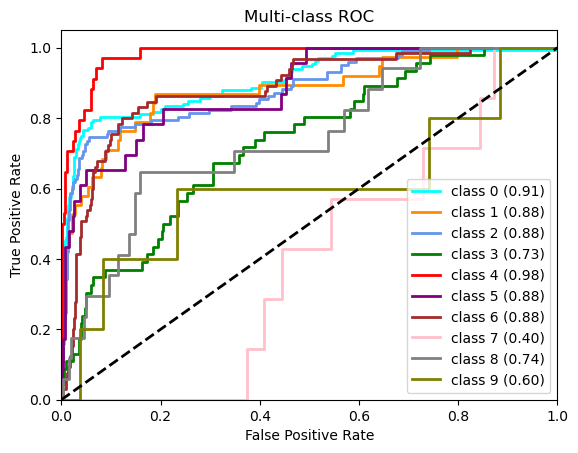

In [8]:
# ROC plot for multi-class
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs).cpu().numpy()
        labels = labels.cpu().numpy()
        
        all_preds.extend(outputs)
        all_labels.extend(labels)

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

n_classes = all_labels.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels[:, i], all_preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'class {i} ({roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC')
plt.legend(loc="lower right")
plt.show()

# 統一寫在一起train，但似乎比較慢

In [ ]:
selected_data  = 'original' # 'original' or 'augmented' to evaluate the model on the original or augmented dataset
loss_labels = 'all' # 'all' or 'unk'for all labels or only unknown labels loss respectively
ctran_model = False # True for CTran, False for CNN
if ctran_model:
    optimizer = optim.Adam(model.parameters(), lr=0.00001)
else:
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
num_epochs = 30

total_size = len(train_dataset)
val_size = int(total_size * 0.2)
train_size = total_size - val_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

best_val_loss = float('inf')
best_model_state = None
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for batch in train_loader:
        if ctran_model:
            labels = batch['labels'].float()
            images = batch['image'].float()
            mask = batch['mask'].float()
            unk_mask = custom_replace(mask,1,0,0)
            mask_in = mask.clone()
            
            optimizer.zero_grad()
            outputs,int_pred,attns = model(images.to(device),mask_in.to(device))
            
            loss =  F.binary_cross_entropy_with_logits(outputs.view(labels.size(0),-1),labels.cuda(),reduction='none')
            if loss_labels == 'unk': 
                # only use unknown labels for loss
                loss_out = (unk_mask.cuda()*loss).sum()
            else: 
                # use all labels for loss
                loss_out = loss.sum()
                
        else:
            inputs, labels = batch['image'].to(device), batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            # print(outputs.shape, labels.shape)
            loss_out = F.binary_cross_entropy_with_logits(outputs, labels, reduction='none').sum() # sigmoid + BCELoss
        
        train_loss += loss_out.item()
        loss_out.backward()
        optimizer.step()

    # Evaluate the model on the validation set
    model.eval()
    val_loss = 0.0
    # correct_predictions = 0
    total_jaccard_index = 0.0
    total_samples = 0
    auc_scores = []

    with torch.no_grad():
        all_preds = []
        all_labels = []
        all_preds_4 = []
        all_labels_4 = []
        all_preds_5 = []
        all_labels_5 = []
        for batch in val_loader:
            if ctran_model:
                labels = batch['labels'].float()
                images = batch['image'].float()
                mask = batch['mask'].float()
                mask_in = mask.clone()
                unk_mask = custom_replace(mask,1,0,0)
                
                outputs,int_pred,attns = model(images.to(device),mask_in.to(device))
                
                loss = F.binary_cross_entropy_with_logits(outputs.view(labels.size(0),-1),labels.cuda(), reduction='none')
                loss_out = (unk_mask.cuda()*loss).sum()
            else:
                inputs, labels = batch['image'].to(device), batch['labels'].to(device)
                outputs = model(inputs)
                loss_out = F.binary_cross_entropy_with_logits(outputs, labels, reduction='none').sum()
                
            val_loss += loss_out.item()

            # Calculate accuracy
            ## method 1. Strictly Accuracy
            # predicted_labels = (outputs > 0.5).float()
            # correct_predictions += (predicted_labels == labels).all(dim=1).sum().item()
            # total_samples += labels.size(0)
            
            ## method 2. Jaccard Accuracy
            # predicted = (outputs > 0.5).bool()
            # labels_bool = labels.bool()
            # intersection = (predicted & labels_bool).float().sum(dim=1)
            # union = (predicted | labels_bool).float().sum(dim=1)
            # jaccard_index_per_example = intersection / union
            # jaccard_index_per_example[union == 0] = 1.0
            # total_jaccard_index += jaccard_index_per_example.sum().item()
            # total_samples += labels.size(0)
            
            ## method 3. AUC
            outputs_np = F.sigmoid(outputs).cpu().numpy()
            labels_np = labels.cpu().numpy()
            all_preds.extend(outputs_np)
            all_labels.extend(labels_np)
            
            ## method 4. mAP
            all_preds_4.append(F.sigmoid(outputs).cpu())
            all_labels_4.append(labels.cpu())
            
            ## method 5. F1 Score
            predicted = F.sigmoid(outputs).cpu() > 0.5
            all_preds_5.append(predicted.numpy())
            all_labels_5.append(labels.cpu().numpy())

    current_val_loss = val_loss / len(val_loader)
    if current_val_loss < best_val_loss:
        best_val_loss = current_val_loss
        best_model_state = copy.deepcopy(model.state_dict())
    
    if selected_data == 'original':
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss/len(train_loader):.6f}, Validation Loss: {val_loss/len(val_loader):.6f}')
        continue
    
    ## method 1.
    # accuracy = correct_predictions / total_samples
    ## method 2.
    # accuracy = total_jaccard_index / total_samples
    ## method 3.
    for i in range(labels_np.shape[1]):
            label_specific_auc = roc_auc_score([label[i] for label in all_labels], [pred[i] for pred in all_preds])
            auc_scores.append(label_specific_auc)
    average_auc = sum(auc_scores) / len(auc_scores)
    ## method 4. mAP
    all_preds_4 = torch.cat(all_preds_4).numpy()
    all_labels_4 = torch.cat(all_labels_4).numpy()
    mAP = 0
    for i in range(all_labels_4.shape[1]):
        AP = average_precision_score(all_labels_4[:, i], all_preds_4[:, i])
        mAP += AP

    mAP /= all_labels_4.shape[1]
    ## method 5. F1 Score
    all_preds_5 = np.vstack(all_preds_5)
    all_labels_5 = np.vstack(all_labels_5)
    f1_macro = f1_score(all_labels_5, all_preds_5, average='macro')
    
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss/len(train_loader):.6f}, Validation Loss: {val_loss/len(val_loader):.6f}, F1_macro: {f1_macro:.3f}, Average AUC: {average_auc:.3f}, mAP: {mAP:.3f}')

In [ ]:
num_epochs = 10

best_val_loss = float('inf')
best_model_state = None

kf = KFold(n_splits=5, shuffle=True, random_state=42)
for fold, (train_idx, val_idx) in enumerate(kf.split(np.arange(len(train_dataset)))):
    print(f"------------------ Fold {fold + 1}/{kf.get_n_splits()} --------------------")
    
    train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
    val_sampler = torch.utils.data.SubsetRandomSampler(val_idx)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
    val_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=val_sampler)
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for batch in train_loader:
            if ctran_model:
                labels = batch['labels'].float()
                images = batch['image'].float()
                mask = batch['mask'].float()
                unk_mask = custom_replace(mask,1,0,0)
                mask_in = mask.clone()
                
                optimizer.zero_grad()
                outputs,int_pred,attns = model(images.to(device),mask_in.to(device))
                
                loss =  F.binary_cross_entropy_with_logits(outputs.view(labels.size(0),-1),labels.cuda(),reduction='none')
                if loss_labels == 'unk': 
                    # only use unknown labels for loss
                    loss_out = (unk_mask.cuda()*loss).sum()
                else: 
                    # use all labels for loss
                    loss_out = loss.sum()
                    
            else:
                inputs, labels = batch['image'].to(device), batch['labels'].to(device)

                optimizer.zero_grad()
                outputs = model(inputs)
                # print(outputs.shape, labels.shape)
                loss_out = F.binary_cross_entropy_with_logits(outputs, labels, reduction='none'),sum() # sigmoid + BCELoss
                
            train_loss += loss_out.item()
            loss_out.backward()
            optimizer.step()

        # Evaluate the model on the validation set
        model.eval()
        val_loss = 0.0
        # correct_predictions = 0
        total_jaccard_index = 0.0
        total_samples = 0
        auc_scores = []

        with torch.no_grad():
            
            all_preds = []
            all_labels = []
            all_preds_4 = []
            all_labels_4 = []
            all_preds_5 = []
            all_labels_5 = []
            
            for batch in val_loader:
                if ctran_model:
                    labels = batch['labels'].float()
                    images = batch['image'].float()
                    mask = batch['mask'].float()
                    mask_in = mask.clone()
                    unk_mask = custom_replace(mask,1,0,0)
                    
                    outputs,int_pred,attns = model(images.to(device),mask_in.to(device))
                    
                    loss = F.binary_cross_entropy_with_logits(outputs.view(labels.size(0),-1),labels.cuda(), reduction='none')
                    loss_out = (unk_mask.cuda()*loss).sum()
                else:
                    inputs, labels = batch['image'].to(device), batch['labels'].to(device)
                    outputs = model(inputs)
                    loss_out = F.binary_cross_entropy_with_logits(outputs, labels, reduction='none').sum()
                    
                val_loss += loss_out

                # Calculate accuracy
                ## method 1. Strictly Accuracy
                # predicted_labels = (outputs > 0.5).float()
                # correct_predictions += (predicted_labels == labels).all(dim=1).sum().item()
                # total_samples += labels.size(0)
                
                ## method 2. Jaccard Accuracy
                # predicted = (outputs > 0.5).bool()
                # labels_bool = labels.bool()
                # intersection = (predicted & labels_bool).float().sum(dim=1)
                # union = (predicted | labels_bool).float().sum(dim=1)
                # jaccard_index_per_example = intersection / union
                # jaccard_index_per_example[union == 0] = 1.0
                # total_jaccard_index += jaccard_index_per_example.sum().item()
                # total_samples += labels.size(0)
                
                ## method 3. AUC
            outputs_np = F.sigmoid(outputs).cpu().numpy()
            labels_np = labels.cpu().numpy()
            all_preds.extend(outputs_np)
            all_labels.extend(labels_np)
            
            ## method 4. mAP
            all_preds_4.append(F.sigmoid(outputs).cpu())
            all_labels_4.append(labels.cpu())
            
            ## method 5. F1 Score
            predicted = F.sigmoid(outputs).cpu() > 0.5
            all_preds_5.append(predicted.numpy())
            all_labels_5.append(labels.cpu().numpy())


    ## method 1.
    # accuracy = correct_predictions / total_samples
    ## method 2.
    # accuracy = total_jaccard_index / total_samples
    ## method 3.
    for i in range(labels_np.shape[1]):
            label_specific_auc = roc_auc_score([label[i] for label in all_labels], [pred[i] for pred in all_preds])
            auc_scores.append(label_specific_auc)
    average_auc = sum(auc_scores) / len(auc_scores)
    ## method 4. mAP
    all_preds_4 = torch.cat(all_preds_4).numpy()
    all_labels_4 = torch.cat(all_labels_4).numpy()
    mAP = 0
    for i in range(all_labels_4.shape[1]):
        AP = average_precision_score(all_labels_4[:, i], all_preds_4[:, i])
        mAP += AP

    mAP /= all_labels_4.shape[1]
    ## method 5. F1 Score
    all_preds_5 = np.vstack(all_preds_5)
    all_labels_5 = np.vstack(all_labels_5)
    f1_macro = f1_score(all_labels_5, all_preds_5, average='macro')
    
    current_val_loss = val_loss / len(val_loader)
    if current_val_loss < best_val_loss:
        best_val_loss = current_val_loss
        best_model_state = copy.deepcopy(model.state_dict())
    
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss/len(train_loader):.6f}, Validation Loss: {val_loss/len(val_loader):.6f}, F1_macro: {f1_macro:.3f}, Average AUC: {average_auc:.3f}, mAP: {mAP:.3f}')